# 3장: 첫 번째 GAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-3/Chapter_3_GAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자

In [4]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # 완전 연결층
    model.add(Dense(128, input_dim=z_dim))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # tanh 활성화 함수를 사용한 출력층
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # 생성자의 출력을 이미지 차원으로 변경
    model.add(Reshape(img_shape))

    return model

## 판별자

In [5]:
def build_discriminator(img_shape):

    model = Sequential()

    # 입력 이미지를 일렬로 펼치기
    model.add(Flatten(input_shape=img_shape))

    # 완전 연결층
    model.add(Dense(128))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 시그모이드 활성화 함수를 사용한 출력층
    model.add(Dense(1, activation='sigmoid'))

    return model

## 모델 만들기

In [6]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [7]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(img_shape, z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [8]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [9]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## GAN 훈련과 출력 점검

케라스의 `'Discrepancy between trainable weights and collected trainable'` 경고는 예상한 것입니다. 원래 설계가 판별자를 훈련하는 동안 생성자의 훈련 파라미터를 고의로 일정하게 유지했고 그 반대의 경우도 마찬가지입니다.

1000 [D 손실: 0.098325, 정확도: 97.66%] [G 손실: 3.238143]
2000 [D 손실: 0.059592, 정확도: 97.27%] [G 손실: 7.554916]
3000 [D 손실: 0.085684, 정확도: 96.09%] [G 손실: 6.171673]
4000 [D 손실: 0.149943, 정확도: 94.92%] [G 손실: 5.314441]
5000 [D 손실: 0.420513, 정확도: 83.59%] [G 손실: 4.728847]
6000 [D 손실: 0.373600, 정확도: 86.72%] [G 손실: 4.116784]
7000 [D 손실: 0.282276, 정확도: 87.50%] [G 손실: 4.924949]
8000 [D 손실: 0.251280, 정확도: 89.45%] [G 손실: 4.310280]
9000 [D 손실: 0.422329, 정확도: 82.42%] [G 손실: 3.334042]
10000 [D 손실: 0.262682, 정확도: 87.50%] [G 손실: 3.778268]
11000 [D 손실: 0.313607, 정확도: 86.33%] [G 손실: 3.188749]
12000 [D 손실: 0.383899, 정확도: 82.81%] [G 손실: 4.043803]
13000 [D 손실: 0.445471, 정확도: 78.91%] [G 손실: 3.546646]
14000 [D 손실: 0.416905, 정확도: 81.25%] [G 손실: 2.826509]
15000 [D 손실: 0.529485, 정확도: 76.17%] [G 손실: 2.079391]
16000 [D 손실: 0.661914, 정확도: 72.66%] [G 손실: 2.756926]
17000 [D 손실: 0.427400, 정확도: 80.47%] [G 손실: 2.151478]
18000 [D 손실: 0.455950, 정확도: 78.52%] [G 손실: 2.633879]
19000 [D 손실: 0.435998, 정확도: 80.08%] [G 손실: 2.345287]
20

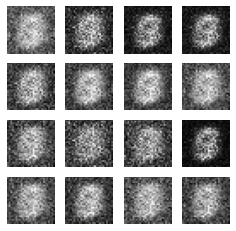

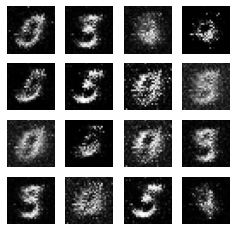

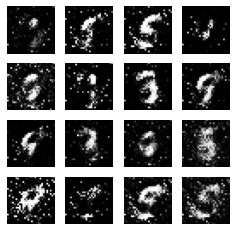

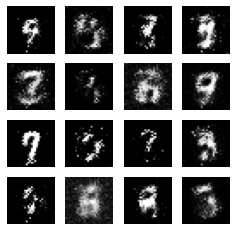

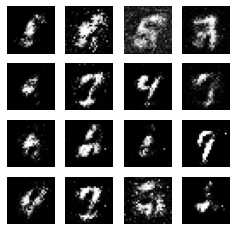

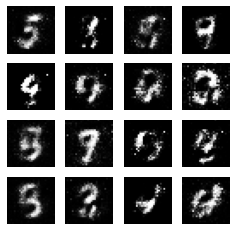

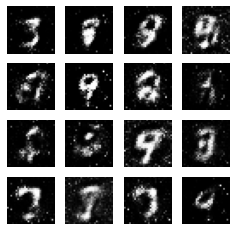

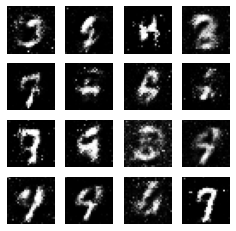

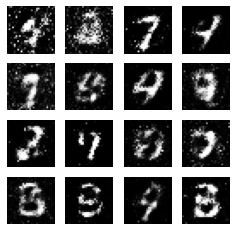

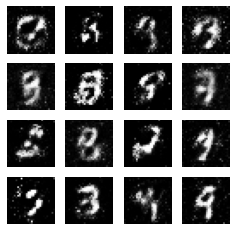

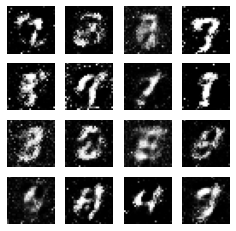

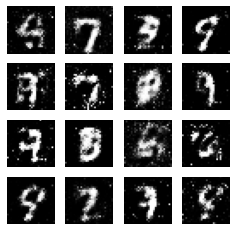

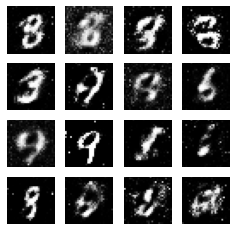

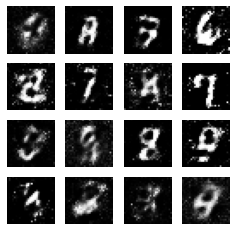

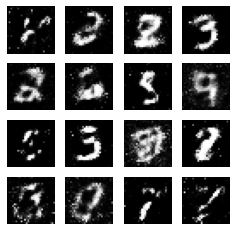

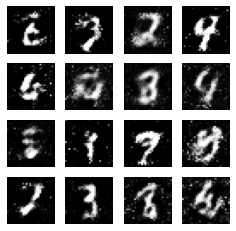

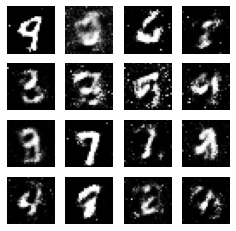

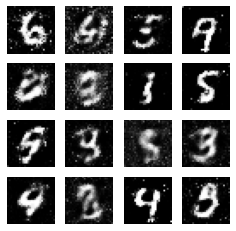

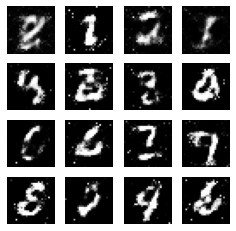

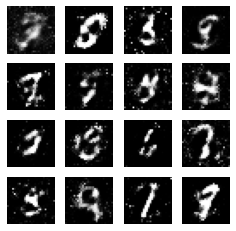

In [10]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval)

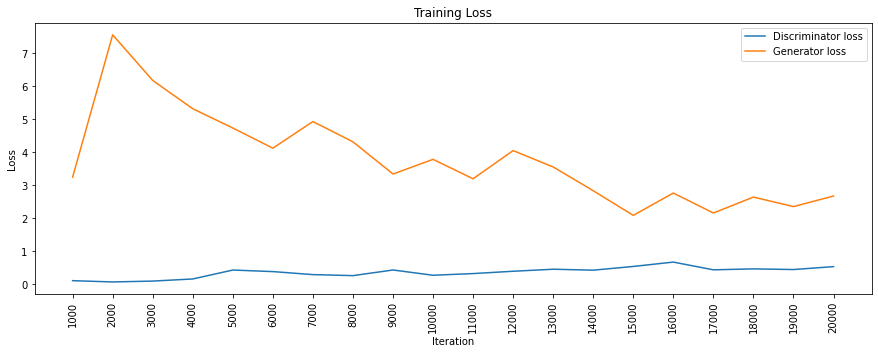

In [11]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

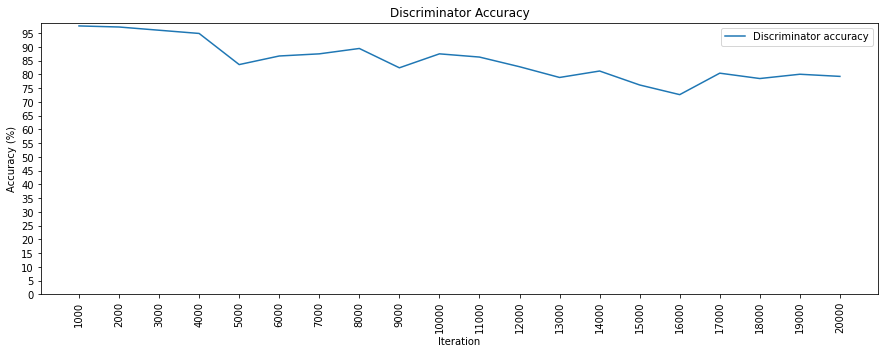

In [12]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()